## lightGBMを使用したアンサンブル

In [4]:
import pandas as pd
import joblib
from sklearn.base import BaseEstimator, ClassifierMixin

# カスタムアンサンブルクラスの定義
class EnsembleModel(BaseEstimator, ClassifierMixin):
    def __init__(self, model1, model2, model3, selected_features_grb, selected_features_cat, selected_features_lgbm, weight1=0.4, weight2=0.3, weight3=0.3):
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        self.selected_features_grb = selected_features_grb
        self.selected_features_cat = selected_features_cat
        self.selected_features_lgbm = selected_features_lgbm
        self.weight1 = weight1
        self.weight2 = weight2
        self.weight3 = weight3


    def fit(self, X, y=None):
        # モデルのトレーニングは既に完了しているため、何もしない
        return self

    def predict_proba(self, X):
        # Xには、各モデル用の特徴量が辞書形式で渡される前提
        X_grb = X['grb']
        X_cat = X['cat']
        X_lgbm = X['lgbm']
    
        # 各モデルで予測を行う
        y_pred_proba_model1 = self.model1.predict_proba(X_grb)[:, 1]
        y_pred_proba_model2 = self.model2.predict_proba(X_cat)[:, 1]
        
        # LightGBMのBoosterオブジェクトの場合はpredictを使用
        y_pred_proba_model3 = self.model3.predict(X_lgbm)

        # 予測確率を重み付けして合計
        return (self.weight1 * y_pred_proba_model1 + 
                self.weight2 * y_pred_proba_model2 +
                self.weight3 * y_pred_proba_model3 )


# モデルのロード
grb_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/model/gradient_boosting0921_1.joblib'
cat_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/model/catboost_0920_1_grid.joblib'
lgbm_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/model/lgb_0920_1.joblib'

# 各モデルを定義
grb_model = joblib.load(grb_path)
cat_model = joblib.load(cat_path)
lgbm_model = joblib.load(lgbm_path)

# 各モデルの特徴量セット
selected_features_grb = [
    'ALT_GPT_log', 'T_Bil_log', 'AST_GOT_log',
    'ALP_log', 'D_Bil_log', 'AG_ratio_log', 
    'TP_Alb_ratio', 'Age', 'Gender_Male'
]

selected_features_cat = [
    'T_Bil_log', 'ALT_GPT_log', 'AG_ratio_log', 'AST_GOT_log', 'D_Bil_log', 
    'ALP_log', 'TP_Alb_ratio', 'Age', 'Gender_Male'
]

selected_features_lgbm = [
    'Age', 'T_Bil_log', 'D_Bil_log', 'ALP_log', 'ALT_GPT_log',
    'AST_GOT_log', 'AG_ratio_log', 'TP_Alb_ratio', 'Gender_Male'
]

# アンサンブルモデルの作成
ensemble_model = EnsembleModel(
    model1=grb_model, 
    model2=cat_model,
    model3=lgbm_model,
    selected_features_grb=selected_features_grb,
    selected_features_cat=selected_features_cat,
    selected_features_lgbm=selected_features_lgbm,
)

# テストデータの読み込み
test_data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/test/test_std_scaled_0919_1.csv'
test_df = pd.read_csv(test_data_path)


# アンサンブルモデルを利用して各モデルの予測を実行するため、適切な特徴量だけを選択
test_df_selected = {
    'grb': test_df[selected_features_grb],
    'cat': test_df[selected_features_cat],
    'lgbm': test_df[selected_features_lgbm]
}

# 予測実行
test_y_pred_proba = ensemble_model.predict_proba(test_df_selected)  # クラス1の確率

# 予測結果を DataFrame に追加
test_df['disease'] = test_y_pred_proba

# 予測結果をファイルに保存
output_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/submit/ensemble_model0921_1.csv'
test_df[['disease']].to_csv(output_path, index=False)

print(f"予測結果が {output_path} に保存されました。")



予測結果が /Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/submit/ensemble_model0921_1.csv に保存されました。


## lightGBMなしの加重アンサンブル

In [2]:
import pandas as pd
import joblib
from sklearn.base import BaseEstimator, ClassifierMixin

# カスタムアンサンブルクラスの定義
class EnsembleModel(BaseEstimator, ClassifierMixin):
    def __init__(self, model1, model2, selected_features_grb, selected_features_cat, weight1=0.5, weight2=0.5):
        self.model1 = model1
        self.model2 = model2
        self.selected_features_grb = selected_features_grb
        self.selected_features_cat = selected_features_cat
        self.weight1 = weight1
        self.weight2 = weight2

    def fit(self, X, y=None):
        # モデルのトレーニングは既に完了しているため、何もしない
        return self

    def predict_proba(self, X):
        # Xには、各モデル用の特徴量が辞書形式で渡される前提
        X_grb = X['grb']
        X_cat = X['cat']
    
        # 各モデルで予測を行う
        y_pred_proba_model1 = self.model1.predict_proba(X_grb)[:, 1]
        y_pred_proba_model2 = self.model2.predict_proba(X_cat)[:, 1]

    
        # 予測確率を重み付けして合計
        return (self.weight1 * y_pred_proba_model1 + 
                self.weight2 * y_pred_proba_model2)

# モデルのロード
grb_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/model/gradient_boosting0919_1.joblib'
cat_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/model/catboost_0919_1_grid.joblib'

# 各モデルを定義
grb_model = joblib.load(grb_path)
cat_model = joblib.load(cat_path)


# 各モデルの特徴量セット
selected_features_grb = [
    'T_Bil_log', 'ALT_GPT_log', 'AST_GOT_log',
    'ALP_log', 'D_Bil_log', 'AG_ratio_log', 
    'TP_Alb_ratio', 'Age', 'Gender_Male'
]

selected_features_cat = [
    'T_Bil_log', 'ALT_GPT_log', 'AG_ratio_log', 
    'AST_GOT_log', 'D_Bil_log', 'ALP_log', 'TP_Alb_ratio', 
    'Age', 'Gender_Male'
]


# アンサンブルモデルの作成
ensemble_model = EnsembleModel(
    model1=grb_model, 
    model2=cat_model, 
    selected_features_grb=selected_features_grb, 
    selected_features_cat=selected_features_cat, 
)

# テストデータの読み込み
test_data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/test/test_scaled_robust_0919_1.csv'
test_df = pd.read_csv(test_data_path)

# アンサンブルモデルを利用して各モデルの予測を実行するため、適切な特徴量だけを選択
test_df_selected = {
    'grb': test_df[selected_features_grb],
    'cat': test_df[selected_features_cat]
}

# 予測実行
test_y_pred_proba = ensemble_model.predict_proba(test_df_selected)  # クラス1の確率

# 予測結果を DataFrame に追加
test_df['disease'] = test_y_pred_proba


# 必要であれば予測結果をファイルに保存
output_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/submit/ensemble_model0919_1.csv'
test_df.to_csv(output_path, index=False)


## Light GBMを含めてスタッキングモデルを作成する

In [13]:
import pandas as pd
import joblib
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier  # XGBoostのscikit-learn互換クラス
from lightgbm import LGBMClassifier  # LightGBMのscikit-learn互換クラス
from sklearn.model_selection import train_test_split

# モデルのロード
xgb_path = '/Users/hayakawakazue/Downloads/signate/model/xgboost_grid_0921_1.joblib'
cat_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/model/catboost_0920_1_grid.joblib'
lgbm_model = LGBMClassifier()  # LGBMClassifierをscikit-learn互換で使用

# 各モデルを定義
xgb_model = joblib.load(xgb_path)
cat_model = joblib.load(cat_path)


# 各モデルの特徴量セット
selected_features_xgb = [
    'T_Bil_log', 'AST_GOT_log', 'D_Bil_log', 'ALT_GPT_log', 'AG_ratio_log',
    'ALP_log', 'Gender_Male', 'TP_Alb_ratio', 'Age'
]

selected_features_cat = [
    'T_Bil_log', 'ALT_GPT_log', 'AG_ratio_log', 
    'AST_GOT_log', 'D_Bil_log', 'ALP_log', 'TP_Alb_ratio', 
    'Age', 'Gender_Male'
]

selected_features_lgbm = [
    'Age', 'T_Bil_log', 'D_Bil_log', 'ALP_log', 'ALT_GPT_log',
    'AST_GOT_log', 'AG_ratio_log', 'TP_Alb_ratio', 'Gender_Male'
]

# テストデータの読み込み
test_data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/test/test_std_scaled_0919_1.csv'
test_df = pd.read_csv(test_data_path)

# トレーニングデータの読み込み
train_data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_std_scaled_0919_1.csv'
train_df = pd.read_csv(train_data_path)

# 目的変数
y = train_df['disease']

# 各モデルの特徴量を選択し、接頭辞を追加して区別する
X_xgb = train_df[selected_features_xgb].add_prefix('xgb_')
X_cat = train_df[selected_features_cat].add_prefix('cat_')
X_lgbm = train_df[selected_features_lgbm].add_prefix('lgbm_')

# テストデータの特徴量選択し、接頭辞を追加して区別する
X_test_xgb = test_df[selected_features_xgb].add_prefix('xgb_')
X_test_cat = test_df[selected_features_cat].add_prefix('cat_')
X_test_lgbm = test_df[selected_features_lgbm].add_prefix('lgbm_')

# スタッキングアンサンブルの作成
# ベースモデルを定義
estimators = [
    ('xgb', xgb_model),
    ('cat', cat_model),
    ('lgbm', lgbm_model)
]

# メタモデルとしてロジスティック回帰を使用
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5
)

# トレーニングデータの統合
X_train_combined = pd.concat([X_xgb, X_cat, X_lgbm], axis=1)

# テストデータの統合
X_test_combined = pd.concat([X_test_xgb, X_test_cat, X_test_lgbm], axis=1)

# モデルのトレーニング
stacking_model.fit(X_train_combined, y)

# 予測実行
test_y_pred_proba = stacking_model.predict_proba(X_test_combined)[:, 1]  # クラス1の確率

# 予測結果を DataFrame に追加
test_df['disease'] = test_y_pred_proba

# 予測結果をファイルに保存
output_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/submit/stacking_model0921_2.csv'
test_df[['disease']].to_csv(output_path, index=False)

print(f"予測結果が {output_path} に保存されました。")


[LightGBM] [Info] Number of positive: 378, number of negative: 472
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5487
[LightGBM] [Info] Number of data points in the train set: 850, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444706 -> initscore=-0.222085
[LightGBM] [Info] Start training from score -0.222085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 303, number of negative: 377
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead

## LightGBMを使用せずにスタッキングモデルを作成する

In [22]:
import pandas as pd
import joblib
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# モデルのロード
grb_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/model/gradient_boosting0921_1.joblib'
cat_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/model/catboost_0920_1_grid.joblib'
xgb_path = '/Users/hayakawakazue/Downloads/signate/model/xgboost_grid_0921_1.joblib'

# 各モデルを定義
grb_model = joblib.load(grb_path)
cat_model = joblib.load(cat_path)
xgb_model = joblib.load(xgb_path)

# 各モデルの特徴量セット
selected_features_grb = [
    'ALT_GPT_log', 'T_Bil_log', 'AST_GOT_log',
    'ALP_log', 'D_Bil_log', 'AG_ratio_log', 
    'TP_Alb_ratio', 'Age', 'Gender_Male'
]

selected_features_cat = [
    'T_Bil_log', 'ALT_GPT_log', 'AG_ratio_log', 
    'AST_GOT_log', 'D_Bil_log', 'ALP_log', 'TP_Alb_ratio', 
    'Age', 'Gender_Male'
]

selected_features_xgb = [
    'T_Bil_log', 'AST_GOT_log', 'D_Bil_log', 'ALT_GPT_log', 'AG_ratio_log',
    'ALP_log', 'Gender_Male', 'TP_Alb_ratio', 'Age'
]

# テストデータの読み込み
test_data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/test/test_std_scaled_0919_1.csv'
test_df = pd.read_csv(test_data_path)

# トレーニングデータの読み込み
train_data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_std_scaled_0919_1.csv'
train_df = pd.read_csv(train_data_path)

# 目的変数
y = train_df['disease']

# 各モデルの特徴量を選択し、接頭辞を追加して区別する
X_grb = train_df[selected_features_grb].add_prefix('grb_')
X_cat = train_df[selected_features_cat].add_prefix('cat_')
X_xgb = train_df[selected_features_xgb].add_prefix('xgb_')

# テストデータの特徴量選択し、接頭辞を追加して区別する
X_test_grb = test_df[selected_features_grb].add_prefix('grb_')
X_test_cat = test_df[selected_features_cat].add_prefix('cat_')
X_test_xgb = test_df[selected_features_xgb].add_prefix('xgb_')

# スタッキングアンサンブルの作成
# ベースモデルを定義
estimators = [
    ('grb', grb_model),
    ('cat', cat_model),
    ('xgb', xgb_model)
]

# メタモデルとしてロジスティック回帰を使用
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5
)

# トレーニングデータの統合
X_train_combined = pd.concat([X_grb, X_cat, X_xgb], axis=1)

# テストデータの統合
X_test_combined = pd.concat([X_test_grb, X_test_cat, X_test_xgb], axis=1)

# モデルのトレーニング
stacking_model.fit(X_train_combined, y)

# 予測実行
test_y_pred_proba = stacking_model.predict_proba(X_test_combined)[:, 1]  # クラス1の確率

# 予測結果を DataFrame に追加
test_df['disease'] = test_y_pred_proba

# 予測結果をファイルに保存
output_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/submit/stacking_model0921_5.csv'
test_df[['disease']].to_csv(output_path, index=False)

print(f"予測結果が {output_path} に保存されました。")


予測結果が /Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/submit/stacking_model0921_5.csv に保存されました。


# アンサンブルで作成したファイルを提出用に変更する

In [23]:
import pandas as pd

# テストデータの読み込み
submit_data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/submit/stacking_model0921_5.csv'  # 実際のテストデータのパスに置き換えてください
submit_df = pd.read_csv(submit_data_path)

# 提出用のフォーマットに変更
# インデックスを保持し、disease列のみを使用する
submit_df = submit_df[['disease']]

# 提出する形式にしてファイルを保存（ヘッダーとインデックスを含めない）
output_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/submit/submit_0921_6.csv'
submit_df.to_csv(output_path, index=True, header=False)

submit_df.head(20)


,disease
0,0.056798
1,0.146170
2,0.058116
3,0.079088
4,0.067150
5,0.064146
6,0.922093
7,0.834429
8,0.886357
9,0.227678


# 単体モデルを使用してテストデータの予測する

In [3]:
import pandas as pd
import numpy as np
import joblib

# 保存したモデルのパス
model_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/model/catboost_0920_1_grid.joblib'

# 評価用 test_csvデータ確認
test_data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/test/test_scaled_robust_0919_1.csv'
test_df = pd.read_csv(test_data_path)

# トレーニング時に使用した特徴量
selected_features = [
    'T_Bil_log', 'ALT_GPT_log', 'AG_ratio_log', 'AST_GOT_log', 'D_Bil_log', 
    'ALP_log', 'TP_Alb_ratio', 'Age', 'Gender_Male'
]

# テストデータから、トレーニング時に使用した特徴量だけを選択
test_df_selected = test_df[selected_features]

# 保存したモデルをロード
with open(model_path, 'rb') as model_file:
    best_model = joblib.load(model_file)

# モデルを使ってテストデータを予測（クラス1の確率を取得）
test_y_pred_proba = best_model.predict_proba(test_df_selected)[:, 1]  # クラス1の確率

# ID列と予測値をまとめてCSVに保存
submit_df = pd.DataFrame({
    'id': test_df.index,  # インデックス列を使用
    'prediction': test_y_pred_proba  # 0〜1の確率
})

# ヘッダーなしでCSVファイルに保存
submit_df.to_csv('/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/submit/submit_0920_2.csv', header=False, index=False)

print("予測結果を保存しました。")


予測結果を保存しました。


In [6]:
### light GBMで実際のテストデータを予測する

In [2]:
import pandas as pd
import joblib
import numpy as np

# 保存したモデルのパス
model_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/model/lgb_0920_1.joblib'

# 評価用 test_csvデータ確認
test_data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/test/test_std_scaled_0919_1.csv'
test_df = pd.read_csv(test_data_path)

# トレーニング時に使用した特徴量
selected_features = [
    'Age', 'T_Bil_log', 'D_Bil_log', 'ALP_log', 'ALT_GPT_log',
    'AST_GOT_log', 'AG_ratio_log', 'TP_Alb_ratio', 'Gender_Male'
]

# テストデータから、トレーニング時に使用した特徴量だけを選択
test_df_selected = test_df[selected_features]

# 保存したモデルをロード
with open(model_path, 'rb') as model_file:
    best_model = joblib.load(model_file)

# モデルを使ってテストデータを予測
# 'predict' を使用して確率を出力する
test_y_pred_proba = best_model.predict(test_df_selected, num_iteration=best_model.best_iteration, raw_score=False)

# 確率が1次元配列として出力されるため、そのまま使う
# ID列と予測値をまとめてCSVに保存
submit_df = pd.DataFrame({
    'id': test_df.index,  # インデックス列を使用
    'prediction': test_y_pred_proba  # 0〜1の確率
})

# ヘッダーなしでCSVファイルに保存
submit_df.to_csv('/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/submit/submit_0920_1.csv', header=False, index=False)

print("予測結果を保存しました。")


予測結果を保存しました。


# アンサンブルモデルを使用（選択した特徴量の順番も同じ場合）

In [1]:
import pandas as pd
import joblib
from sklearn.base import BaseEstimator, ClassifierMixin

# カスタムアンサンブルクラスの定義
class EnsembleModel(BaseEstimator, ClassifierMixin):
    def __init__(self, model1, model2, model3, model4, selected_features, weight1=0.2, weight2=0.2, weight3=0.3, weight4=0.3):
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        self.model4 = model4
        self.selected_features = selected_features
        self.weight1 = weight1
        self.weight2 = weight2
        self.weight3 = weight3
        self.weight4 = weight4

    def fit(self, X, y=None):
        # モデルのトレーニングは既に完了しているため、何もしない
        return self

    def predict_proba(self, X):
        # 選択した特徴量のみを使用して予測
        X_selected = X[self.selected_features]
        y_pred_proba_model1 = self.model1.predict_proba(X_selected)[:, 1]
        y_pred_proba_model2 = self.model2.predict_proba(X_selected)[:, 1]
        y_pred_proba_model3 = self.model3.predict_proba(X_selected)[:, 1]
        y_pred_proba_model4 = self.model4.predict_proba(X_selected)[:, 1]
        # 予測確率を重み付けして合計
        return (self.weight1 * y_pred_proba_model1 + self.weight2 * y_pred_proba_model2 + self.weight3 * y_pred_proba_model3 + self.weight4 * y_pred_proba_model4)

# アンサンブルモデルのロード
ensemble_model_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/model/ensemble_model0908_1.joblib'
ensemble_model = joblib.load(ensemble_model_path)

# テストデータの読み込み
test_data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/test/test_drop_age_alb_tp.csv'
test_df = pd.read_csv(test_data_path)

# 選択した特徴量（ここをどうするかわかりません。）
selected_features = [
    'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 
    'AG_ratio', 'Alb_ALT_Ratio', 'TP_AST_Ratio'
]

# テストデータから選択した特徴量のみを抽出
test_df_selected = test_df[selected_features]

# disease の予測 (確率ではなく0または1として)
disease_proba = ensemble_model.predict_proba(test_df_selected)
threshold = 0.5  # ここで閾値を0.5に設定
disease_predictions = (disease_proba >= threshold).astype(int)


# 結果を DataFrame に追加
test_df['disease'] = disease_predictions

# 0と1の割合を確認
disease_distribution = test_df['disease'].value_counts(normalize=True) * 100
print("テストデータのProdTakenの割合:")
print(disease_distribution)

# 必要であれば予測結果をファイルに保存
output_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/submit/ensemble_model0908_1.joblib'
test_df.to_csv(output_path, index=False)


ValueError: feature_names mismatch: ['T_Bil', 'Alb_ALT_Ratio', 'TP_AST_Ratio', 'AST_GOT', 'D_Bil', 'ALP', 'AG_ratio', 'ALT_GPT'] ['T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'AG_ratio', 'Alb_ALT_Ratio', 'TP_AST_Ratio']

# モデルが予測するクラスの分布を確認すす（閾値の調整）

In [2]:
import pandas as pd
import joblib

# rfモデルのロード
rf_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/model/lgb_best_model.pkl'
rf_model = joblib.load(rf_path)

# テストデータの読み込み
test_data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_drop_gender.csv'
test_df = pd.read_csv(test_data_path)

# 使用する特徴量を選択
selected_features = [
    'Age', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 
    'Alb', 'AG_ratio'    
]

# テストデータから選択した特徴量のみを抽出
test_df_selected = test_df[selected_features]

# disease の予測 (確率ではなく0または1として)
# 1クラスの確率を取り出し、しきい値0.5を適用して0または1に変換
prod_taken_proba = rf_model.predict_proba(test_df_selected)[:, 1]
threshold = 0.5 # ここで閾値を0.5に設定
prod_taken_predictions = (prod_taken_proba >= threshold).astype(int)

# 結果を DataFrame に追加
test_df['disease'] = prod_taken_predictions

# 0と1の割合を確認
prod_taken_distribution = test_df['disease'].value_counts(normalize=True) * 100
print("テストデータのdiseaseの割合:")
print(prod_taken_distribution)

# 必要であれば予測結果をファイルに保存
# output_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/prediction/predict_0904_1.csv'
# test_df.to_csv(output_path, index=False)


AttributeError: 'Booster' object has no attribute 'predict_proba'

In [6]:
import pandas as pd
import joblib

# モデルのロード
rf_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/model/lgb_best_model.pkl'
rf_model = joblib.load(rf_path)

# テストデータの読み込み
test_data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_drop_gender.csv'
test_df = pd.read_csv(test_data_path)

# 使用する特徴量を選択
selected_features = [
    'Age', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 
    'Alb', 'AG_ratio'    
]

# テストデータから選択した特徴量のみを抽出
test_df_selected = test_df[selected_features]

# disease の予測 (確率を予測して0または1に変換)
prod_taken_proba = rf_model.predict(test_df_selected)  # 'predict'を使用

# 0.5を閾値にして、0または1に変換
threshold = 0.515
prod_taken_predictions = (prod_taken_proba >= threshold).astype(int)

# 結果を DataFrame に追加
test_df['disease'] = prod_taken_predictions

# 0と1の割合を確認
prod_taken_distribution = test_df['disease'].value_counts(normalize=True) * 100
print("テストデータのdiseaseの割合:")
print(prod_taken_distribution)

# 必要であれば予測結果をファイルに保存
# output_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/prediction/predict_0904_1.csv'
# test_df.to_csv(output_path, index=False)


テストデータのdiseaseの割合:
disease
0    55.529412
1    44.470588
Name: proportion, dtype: float64


## クラス分布の割合を確認

Class Distribution:
disease
0    472
1    378
Name: count, dtype: int64

Class Percentage:
disease
0    55.529412
1    44.470588
Name: proportion, dtype: float64


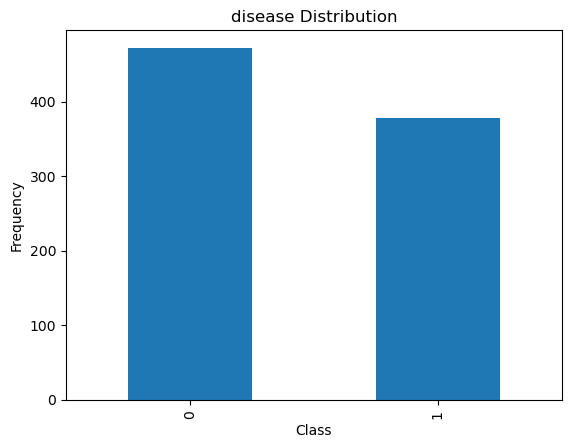

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# データセットの読み込み
data = pd.read_csv('/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/test/train.csv')

# "ProdTaken"のクラス分布を確認
class_distribution = data['disease'].value_counts()
print("Class Distribution:")
print(class_distribution)

# クラスの割合を確認
class_percentage = data['disease'].value_counts(normalize=True) * 100
print("\nClass Percentage:")
print(class_percentage)

# ヒストグラムを作成して視覚的に確認
class_distribution.plot(kind='bar')
plt.title('disease Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# クラスの分布を調整し提出用ファイルを作成する

In [70]:
import pandas as pd

# データセットの読み込み
data = pd.read_csv('/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/prediction/predict_0903_8.csv')

# 必要な列 'disease' だけを残す
data = data[['disease']]

# sample_submit.csvの形式に合わせる
sample_submit = pd.read_csv('/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/submit/sample_submit.csv', header=None)

# 'disease' 列を番号付きで保存
data.insert(0, 'id', sample_submit[0])

# 列名を削除して保存
output_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/prediction/predict_0903_9.csv'
data.to_csv(output_path, header=False, index=False)

# 保存完了メッセージ
print(f"ファイルが{output_path}に保存されました。")


ファイルが/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/prediction/predict_0903_9.csvに保存されました。
